In [52]:
import scanpy as sc
adamson = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Adamson2016/Adamson2016_all_genes.h5ad')
norman = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_all_genes.h5ad')

In [7]:
import numpy as np

np.intersect1d(adamson.obs.condition.unique(), norman.obs.condition.unique())

array(['ctrl'], dtype=object)

In [42]:
from utils import parse_any_pert
n_perts = []
a_perts = []

for i in norman.obs.condition.unique():
    if i != 'ctrl':
        n_perts = n_perts + parse_any_pert(i)

for j in adamson.obs.condition.unique():
    if j != 'ctrl':
        a_perts = a_perts + parse_any_pert(j)

In [43]:
np.intersect1d(n_perts, a_perts)

array([], dtype='<U8')

In [53]:
gene_list_a = adamson.var.gene_name.values
gene_list_n = norman.var.gene_name.values

In [45]:
np.intersect1d(gene_list_n, gene_list_a)

array(['AAK1', 'AASS', 'ABAT', ..., 'ZSWIM4', 'ZSWIM8', 'ZYX'],
      dtype=object)

In [63]:
len(np.intersect1d(gene_list_n, gene_list_a))

15635

In [54]:
len(np.intersect1d(gene_list_n, n_perts))

105

In [55]:
len(np.unique(n_perts))

105

In [56]:
len(np.intersect1d(np.intersect1d(gene_list_n, gene_list_a), n_perts))

97

In [57]:
len(np.intersect1d(np.intersect1d(gene_list_n, gene_list_a), a_perts))

84

In [58]:
len(np.intersect1d(gene_list_n, a_perts))

84

In [59]:
len(a_perts)

86

In [60]:
len(np.intersect1d(gene_list_a, n_perts))

97

In [61]:
adamson

AnnData object with n_obs × n_vars = 69249 × 16528
    obs: 'guide_identity', 'UMI_count', 'gem_group', 'good_coverage', 'number_of_cells', 'perturbed', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [62]:
norman

AnnData object with n_obs × n_vars = 91205 × 24665
    obs: 'guide_identity', 'UMI_count', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'gene_name', 'mean', 'std', 'cv', 'fano', 'in_matrix'
    layers: 'counts'

In [67]:
adamsom_ctrl = adamson.X[adamson.obs.condition == 'ctrl'].toarray()
norman_ctrl = norman.X[norman.obs.condition == 'ctrl'].toarray()

In [68]:
shared_genes = np.intersect1d(gene_list_n, gene_list_a)

In [71]:
np.isin(gene_list_a, shared_genes)

16528

In [82]:
gene_index_shared_a = [np.where(gene_list_a == i)[0][0] for i in shared_genes]
gene_index_shared_n = [np.where(gene_list_n == i)[0][0] for i in shared_genes]

In [83]:
adamson_ctrl_mean_shared = np.mean(adamsom_ctrl[:, gene_index_shared_a], axis = 0)
norman_ctrl_mean_shared = np.mean(norman_ctrl[:, gene_index_shared_n], axis = 0)

In [84]:
norman_ctrl_mean_shared.shape

(15635,)

In [85]:
adamson_ctrl_mean_shared.shape

(15635,)

In [86]:
adamson_ctrl_mean_shared

array([0.19075479, 0.02885861, 0.35032082, ..., 0.1352876 , 0.05029039,
       0.1709597 ], dtype=float32)

In [87]:
norman_ctrl_mean_shared

array([0.24580754, 0.02288895, 0.18921098, ..., 0.19522466, 0.05271349,
       0.1479242 ], dtype=float32)

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

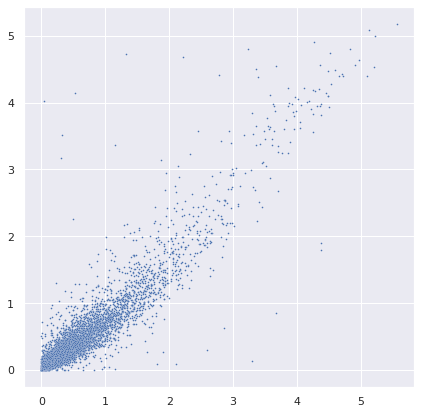

In [89]:
import seaborn as sns
sns.set(rc={'figure.figsize':(7, 7)})

sns.scatterplot(adamson_ctrl_mean_shared, norman_ctrl_mean_shared, s = 3)

In [90]:
from scipy.stats import pearsonr
pearsonr(adamson_ctrl_mean_shared, norman_ctrl_mean_shared)

(0.9410465864505129, 0.0)

In [91]:
X_adamson = adamson.X[:, gene_index_shared_a]
X_norman = norman.X[:, gene_index_shared_n]

In [95]:
a_perts_in_shared = np.intersect1d(shared_genes, a_perts)
n_perts_in_shared = np.intersect1d(shared_genes, n_perts)

In [97]:
len(n_perts_in_shared)

97

In [99]:
genes_to_keep = a_perts_in_shared.tolist() + n_perts_in_shared.tolist()

In [117]:
norman_new = norman[:, gene_index_shared_n]

In [118]:
sc.pp.highly_variable_genes(norman_new,n_top_genes=5000, subset=False)

Trying to set attribute `.uns` of view, copying.


In [119]:
## use the source HVG genes
norman_new.var['highly_variable'] = norman_new.var['highly_variable'] + norman_new.var.gene_name.isin(genes_to_keep)
norman_new = norman_new[:,norman_new.var['highly_variable'] == True]

In [124]:
adamson_new = adamson[:, adamson.var.gene_name.isin(norman_new.var.gene_name.values) == True]

In [125]:
adamson_new

View of AnnData object with n_obs × n_vars = 69249 × 5093
    obs: 'guide_identity', 'UMI_count', 'gem_group', 'good_coverage', 'number_of_cells', 'perturbed', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [136]:
x = 'KLF1+MAP2K6'

def detect_not_in_shared(x, n_perts_in_shared):
    flag = True
    if x != 'ctrl':
        for i in parse_any_pert(x):
            if i not in n_perts_in_shared:
                flag = False
    return flag

In [137]:
detect_not_in_shared(x, n_perts_in_shared)

True

In [144]:
import scanpy as sc
import pandas as pd

def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    pool_doses=False,
    n_genes=50,
    rankby_abs=True,
    key_added='rank_genes_groups_cov',
    return_dict=False,
):

    """
    Function that generates a list of differentially expressed genes computed
    separately for each covariate category, and using the respective control
    cells as reference.

    Usage example:

    rank_genes_groups_by_cov(
        adata,
        groupby='cov_product_dose',
        covariate_key='cell_type',
        control_group='Vehicle_0'
    )

    Parameters
    ----------
    adata : AnnData
        AnnData dataset
    groupby : str
        Obs column that defines the groups, should be
        cartesian product of covariate_perturbation_cont_var,
        it is important that this format is followed.
    control_group : str
        String that defines the control group in the groupby obs
    covariate : str
        Obs column that defines the main covariate by which we
        want to separate DEG computation (eg. cell type, species, etc.)
    n_genes : int (default: 50)
        Number of DEGs to include in the lists
    rankby_abs : bool (default: True)
        If True, rank genes by absolute values of the score, thus including
        top downregulated genes in the top N genes. If False, the ranking will
        have only upregulated genes at the top.
    key_added : str (default: 'rank_genes_groups_cov')
        Key used when adding the dictionary to adata.uns
    return_dict : str (default: False)
        Signals whether to return the dictionary or not

    Returns
    -------
    Adds the DEG dictionary to adata.uns

    If return_dict is True returns:
    gene_dict : dict
        Dictionary where groups are stored as keys, and the list of DEGs
        are the corresponding values

    """

    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        print(cov_cat)
        #name of the control group in the groupby obs column
        control_group_cov = '_'.join([cov_cat, control_group])

        #subset adata to cells belonging to a covariate category
        adata_cov = adata[adata.obs[covariate]==cov_cat]

        #compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes
        )

        #add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns['rank_genes_groups']['names'])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()

    adata.uns[key_added] = gene_dict

    if return_dict:
        return gene_dict



In [140]:
norman_filter_cells = norman_new[norman_new.obs.condition.apply(lambda x: detect_not_in_shared(x, n_perts_in_shared)) == True]

In [142]:
adamson_filter_cells = adamson_new[adamson_new.obs.condition.apply(lambda x: detect_not_in_shared(x, a_perts_in_shared)) == True]

In [145]:
# calculate DE genes
rank_genes_groups_by_cov(adamson_filter_cells, 
                         groupby='cov_drug_dose_name', 
                         covariate='cell_type', 
                         control_group='ctrl_1', 
                         n_genes=20,
                         key_added = 'rank_genes_groups_cov')
for i in [50, 100, 200]:
    rank_genes_groups_by_cov(adamson_filter_cells, 
                         groupby='cov_drug_dose_name', 
                         covariate='cell_type', 
                         control_group='ctrl_1', 
                         n_genes=i,
                         key_added = 'rank_genes_groups_cov_top' + str(i))

K562(?)


Trying to set attribute `.uns` of view, copying.
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-pa

K562(?)


Trying to set attribute `.uns` of view, copying.


K562(?)


Trying to set attribute `.uns` of view, copying.


K562(?)


Trying to set attribute `.uns` of view, copying.


In [148]:
# calculate DE genes
rank_genes_groups_by_cov(norman_filter_cells, 
                         groupby='cov_drug_dose_name', 
                         covariate='cell_type', 
                         control_group='ctrl_1', 
                         n_genes=20,
                         key_added = 'rank_genes_groups_cov')
for i in [50, 100, 200]:
    rank_genes_groups_by_cov(norman_filter_cells, 
                         groupby='cov_drug_dose_name', 
                         covariate='cell_type', 
                         control_group='ctrl_1', 
                         n_genes=i,
                         key_added = 'rank_genes_groups_cov_top' + str(i))

A549


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


A549


Trying to set attribute `.uns` of view, copying.


A549


Trying to set attribute `.uns` of view, copying.


A549


Trying to set attribute `.uns` of view, copying.


In [149]:
adamson_filter_cells

AnnData object with n_obs × n_vars = 67545 × 5093
    obs: 'guide_identity', 'UMI_count', 'gem_group', 'good_coverage', 'number_of_cells', 'perturbed', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'hvg', 'rank_genes_groups_cov', 'rank_genes_groups_cov_top50', 'rank_genes_groups_cov_top100', 'rank_genes_groups_cov_top200'
    layers: 'counts'

In [151]:
norman_filter_cells.var = norman_filter_cells.var[['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name']]

In [153]:
norman_filter_cells.obs = norman_filter_cells.obs[['guide_identity', 
                         'UMI_count', 
                         'good_coverage', 
                         'number_of_cells', 
                         'guide_merged', 
                         'dose_val', 
                         'condition', 
                         'cell_type', 
                         'control', 
                         'drug_dose_name', 
                         'cov_drug_dose_name']]

In [154]:
adamson_filter_cells.obs = adamson_filter_cells.obs[['guide_identity', 
                         'UMI_count', 
                         'good_coverage', 
                         'number_of_cells', 
                         'guide_merged', 
                         'dose_val', 
                         'condition', 
                         'cell_type', 
                         'control', 
                         'drug_dose_name', 
                         'cov_drug_dose_name']]

In [157]:
adamson_filter_cells.obs['dataset'] = 'adamson'
norman_filter_cells.obs['dataset'] = 'norman'

In [158]:
adamson_filter_cells

AnnData object with n_obs × n_vars = 67545 × 5093
    obs: 'guide_identity', 'UMI_count', 'good_coverage', 'number_of_cells', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'hvg', 'rank_genes_groups_cov', 'rank_genes_groups_cov_top50', 'rank_genes_groups_cov_top100', 'rank_genes_groups_cov_top200'
    layers: 'counts'

In [156]:
norman_filter_cells

AnnData object with n_obs × n_vars = 85294 × 5093
    obs: 'guide_identity', 'UMI_count', 'good_coverage', 'number_of_cells', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'hvg', 'rank_genes_groups_cov', 'rank_genes_groups_cov_top50', 'rank_genes_groups_cov_top100', 'rank_genes_groups_cov_top200'
    layers: 'counts'

In [159]:
import anndata as ad

In [172]:
sorted_gene_list = sorted(adamson_filter_cells.var.gene_name)

In [175]:
adamson_reorder_idx = [np.where(adamson_filter_cells.var.gene_name.values == i)[0][0] for i in sorted_gene_list]
norman_reorder_idx = [np.where(norman_filter_cells.var.gene_name.values == i)[0][0] for i in sorted_gene_list]

In [177]:
norman_filter_cells = norman_filter_cells[:, norman_reorder_idx]
adamson_filter_cells = adamson_filter_cells[:, adamson_reorder_idx]

In [181]:
norman_filter_cells.write_h5ad('/dfs/project/perturb-gnn/datasets/trans_norman_adamson/norman2019.h5ad')
adamson_filter_cells.write_h5ad('/dfs/project/perturb-gnn/datasets/trans_norman_adamson/adamson2016.h5ad')

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/dfs/user/kex

In [187]:
adamson_filter_cells.obs['split'] = 'test'
adamson_filter_cells.write_h5ad('/dfs/project/perturb-gnn/datasets/trans_norman_adamson/adamson2016.h5ad')

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'split' as categorical


In [188]:
norman_filter_cells.X

<85294x5093 sparse matrix of type '<class 'numpy.float32'>'
	with 70473943 stored elements in Compressed Sparse Row format>

In [189]:
np.mean(adamson_filter_cells.X, axis = 1)

<67545x5093 sparse matrix of type '<class 'numpy.float32'>'
	with 62241930 stored elements in Compressed Sparse Row format>